## Create the Full 3D Airplane

Import

In [18]:
import itertools
import os
import xml.etree.ElementTree as ET
from typing import List, Union

import aerosandbox as asb
import aerosandbox.numpy as np
import pandas as pd
from aerosandbox.geometry import Airfoil, Airplane, Wing, WingXSec
from scipy.linalg import expm, norm

Function Rotate

In [19]:
def rotate_pt(orign_pt, theta_deg, axis=[0, 1, 0]):
    theta = np.radians(theta_deg)
    M0 = expm(np.cross(np.eye(3), axis / norm(axis) * theta))
    return np.dot(M0, orign_pt)

Function to create an Airplane

In [20]:
def Create_airplane_x_sections(
    x_le: List,
    y_le: List,
    z_le: List,
    chords: List,
    twists: List,
    wing_airfoil: Union[asb.Airfoil, List],
) -> asb.Airplane:
    """Create a Aerosandbox Airplane from lists of parameters

    Args:
        x_le (List),y_le (List),z_le (List):  Coordinates of the XSec's leading edge, relative to the wing's leading edge.
        chords (List): section chord [m]
        twists (List): airfoil angle  [deg]
        wing_airfoil (str | List): event a single Airfoil or a list of Airfoil

    Returns:
        asb.Airplane: Aerosandbox Airplane object
    """

    # check if airfoil is an single Airfoil or a list
    if type(wing_airfoil) is asb.Airfoil:
        list_airfoil = itertools.cycle([wing_airfoil])  # create an object able to cycle
    else:  # then the list is passed
        list_airfoil = wing_airfoil

    wings_list = []
    for x_le, y_le, z_le, chord, twist, wing_airfoil in zip(
        x_le, y_le, z_le, chords, twists, list_airfoil
    ):
        wings_list.append(
            asb.WingXSec(  # Root
                xyz_le=[                    
                    x_le,
                    y_le,
                    z_le,
                ],
                chord=chord,
                twist=twist,
                airfoil=wing_airfoil,
            )
        )
    airplane = asb.Airplane(
        name="MainGlider",
        xyz_ref=[0, 0, 0],
        wings=[
            asb.Wing(
                name="Main Wing", symmetric=True, xsecs=wings_list
            ),  # only one wing in Kite/Paraglider
        ],
    )
    return airplane

Function to Import from XFLR5 With Airfoil

In [21]:
def import_from_xflr5_with_airfoils(
    foldername: str,
    force_midle: bool = False,
    derotate=False,
    draw_three_view: bool = False,
) -> asb.Airplane:
    """
    Imports a folder with an XFLR5 `.xml` file and `.dat` airfoil section files and returns an Aerosandbox airplane geometry.

    Args:
        foldername (str): The foldername of the XFLR5 `.xml` file and `.dat` airfoil section files.
        force_midle (bool): Froce rib 0 and 1 with diadral 0  , default = False
        draw_three_view (bool): draw the 3d view, default = False
    Returns:
        An Aerosandbox Airplane object.
    """
    # Gets all files in the folder
    filenames = [
        os.path.join(foldername, f)
        for f in os.listdir(foldername)
        if os.path.isfile(os.path.join(foldername, f))
    ]

    # Find and pop the '.xml' file
    tree = 0  # In case there is no '.xml' file
    for i in range(len(filenames)):
        if ".xml" in filenames[i]:
            tree = ET.parse(filenames.pop(i))
            root = tree.getroot()
            break
    if tree == 0:  # Return an error
        print("the '.xml' file is missing")
        return ()

    # Extract airplane name
    airplane_name = root.find("Plane/Name").text

    # Extract main wing data
    wing_elements = root.findall("Plane/wing")
    mainwing_element = wing_elements[0]
    mainwing_name = mainwing_element.find("Name").text
    mainwing_type = mainwing_element.find("Type").text
    mainwing_position = [
        float(x) for x in mainwing_element.find("Position").text.split(",")
    ]
    mainwing_symmetric = mainwing_element.find("Symetric").text
    mainwing_is_fin = mainwing_element.find("isFin").text
    mainwing_xsecs = []

    sections_element = mainwing_element.find("Sections")
    section_elements = sections_element.findall("Section")
    list_section = []
    for section_element in section_elements:
        xOffset = float(section_element.find("xOffset").text)
        y_position = float(section_element.find("y_position").text)
        dihedral = float(section_element.find("Dihedral").text)
        chord = float(section_element.find("Chord").text)
        twist = float(section_element.find("Twist").text)
        airfoil_name = section_element.find("Left_Side_FoilName").text

        element = {
            "xOffset": xOffset,
            "y_position": y_position,
            "dihedral": dihedral,
            "chord": chord,
            "twist": twist,
            "airfoil_name": airfoil_name,
        }
        list_section.append(element)

    df_section = pd.DataFrame.from_dict(list_section)

    if force_midle:
        print("Rib 0 and 1 will be force to 0 diedral")
        df_section.at[0, "dihedral"] = 0
        df_section.at[1, "dihedral"] = 0

    df_section["diff_y"] = df_section["y_position"].diff().fillna(0)
    df_section["z_step"] = (
        np.tan(np.radians(df_section["dihedral"])) * df_section["diff_y"]
    )

    df_section["z"] = df_section["z_step"].cumsum()

    df_section["LE_point_raw"] = df_section[
        ["xOffset", "y_position", "z"]
    ].values.tolist()

    if derotate:
        angle_derotate = df_section["twist"][0]
        print(f"The glider will be derotate by {angle_derotate}")

        df_section["LE_point"] = df_section["LE_point_raw"].apply(
            rotate_pt, theta_deg=1
        )
        df_section["twist"] = df_section["twist"] - angle_derotate
    else:
        df_section["LE_point"] = df_section["LE_point_raw"]

    for i, row in df_section.iterrows():
        airfoil = 0  # In case of a missing airfoil file
        for airfoilname in filenames:
            if row["airfoil_name"] in airfoilname:
                airfoil = Airfoil(coordinates=airfoilname)
        if airfoil == 0:  # Return an error
            print("airfoil %s is missing in the folder" % row["airfoil_name"])
            return ()

        xsec = WingXSec(
            xyz_le=row["LE_point"],
            chord=row["chord"],
            twist=row["twist"],
            airfoil=airfoil,
        )

        mainwing_xsecs.append(xsec)

    mainwing = Wing(
        name=mainwing_name,
        xsecs=mainwing_xsecs,
        symmetric=(mainwing_symmetric == "true"),
        is_main_wing=(mainwing_type == "MAINWING"),
        is_horizontal_stabilizer=(mainwing_type == "HORIZONTAL_STABILIZER"),
        is_vertical_stabilizer=(mainwing_type == "VERTICAL_STABILIZER"),
        is_fuselage=(mainwing_type == "FUSELAGE"),
    )

    airplane = Airplane(
        name=airplane_name,
        xyz_ref=mainwing_position,
        wings=[mainwing],
    )

    # Draw the 3d view
    if draw_three_view:
        airplane.draw_three_view()

    return airplane  # , df_section

The Main

Rib 0 and 1 will be force to 0 diedral


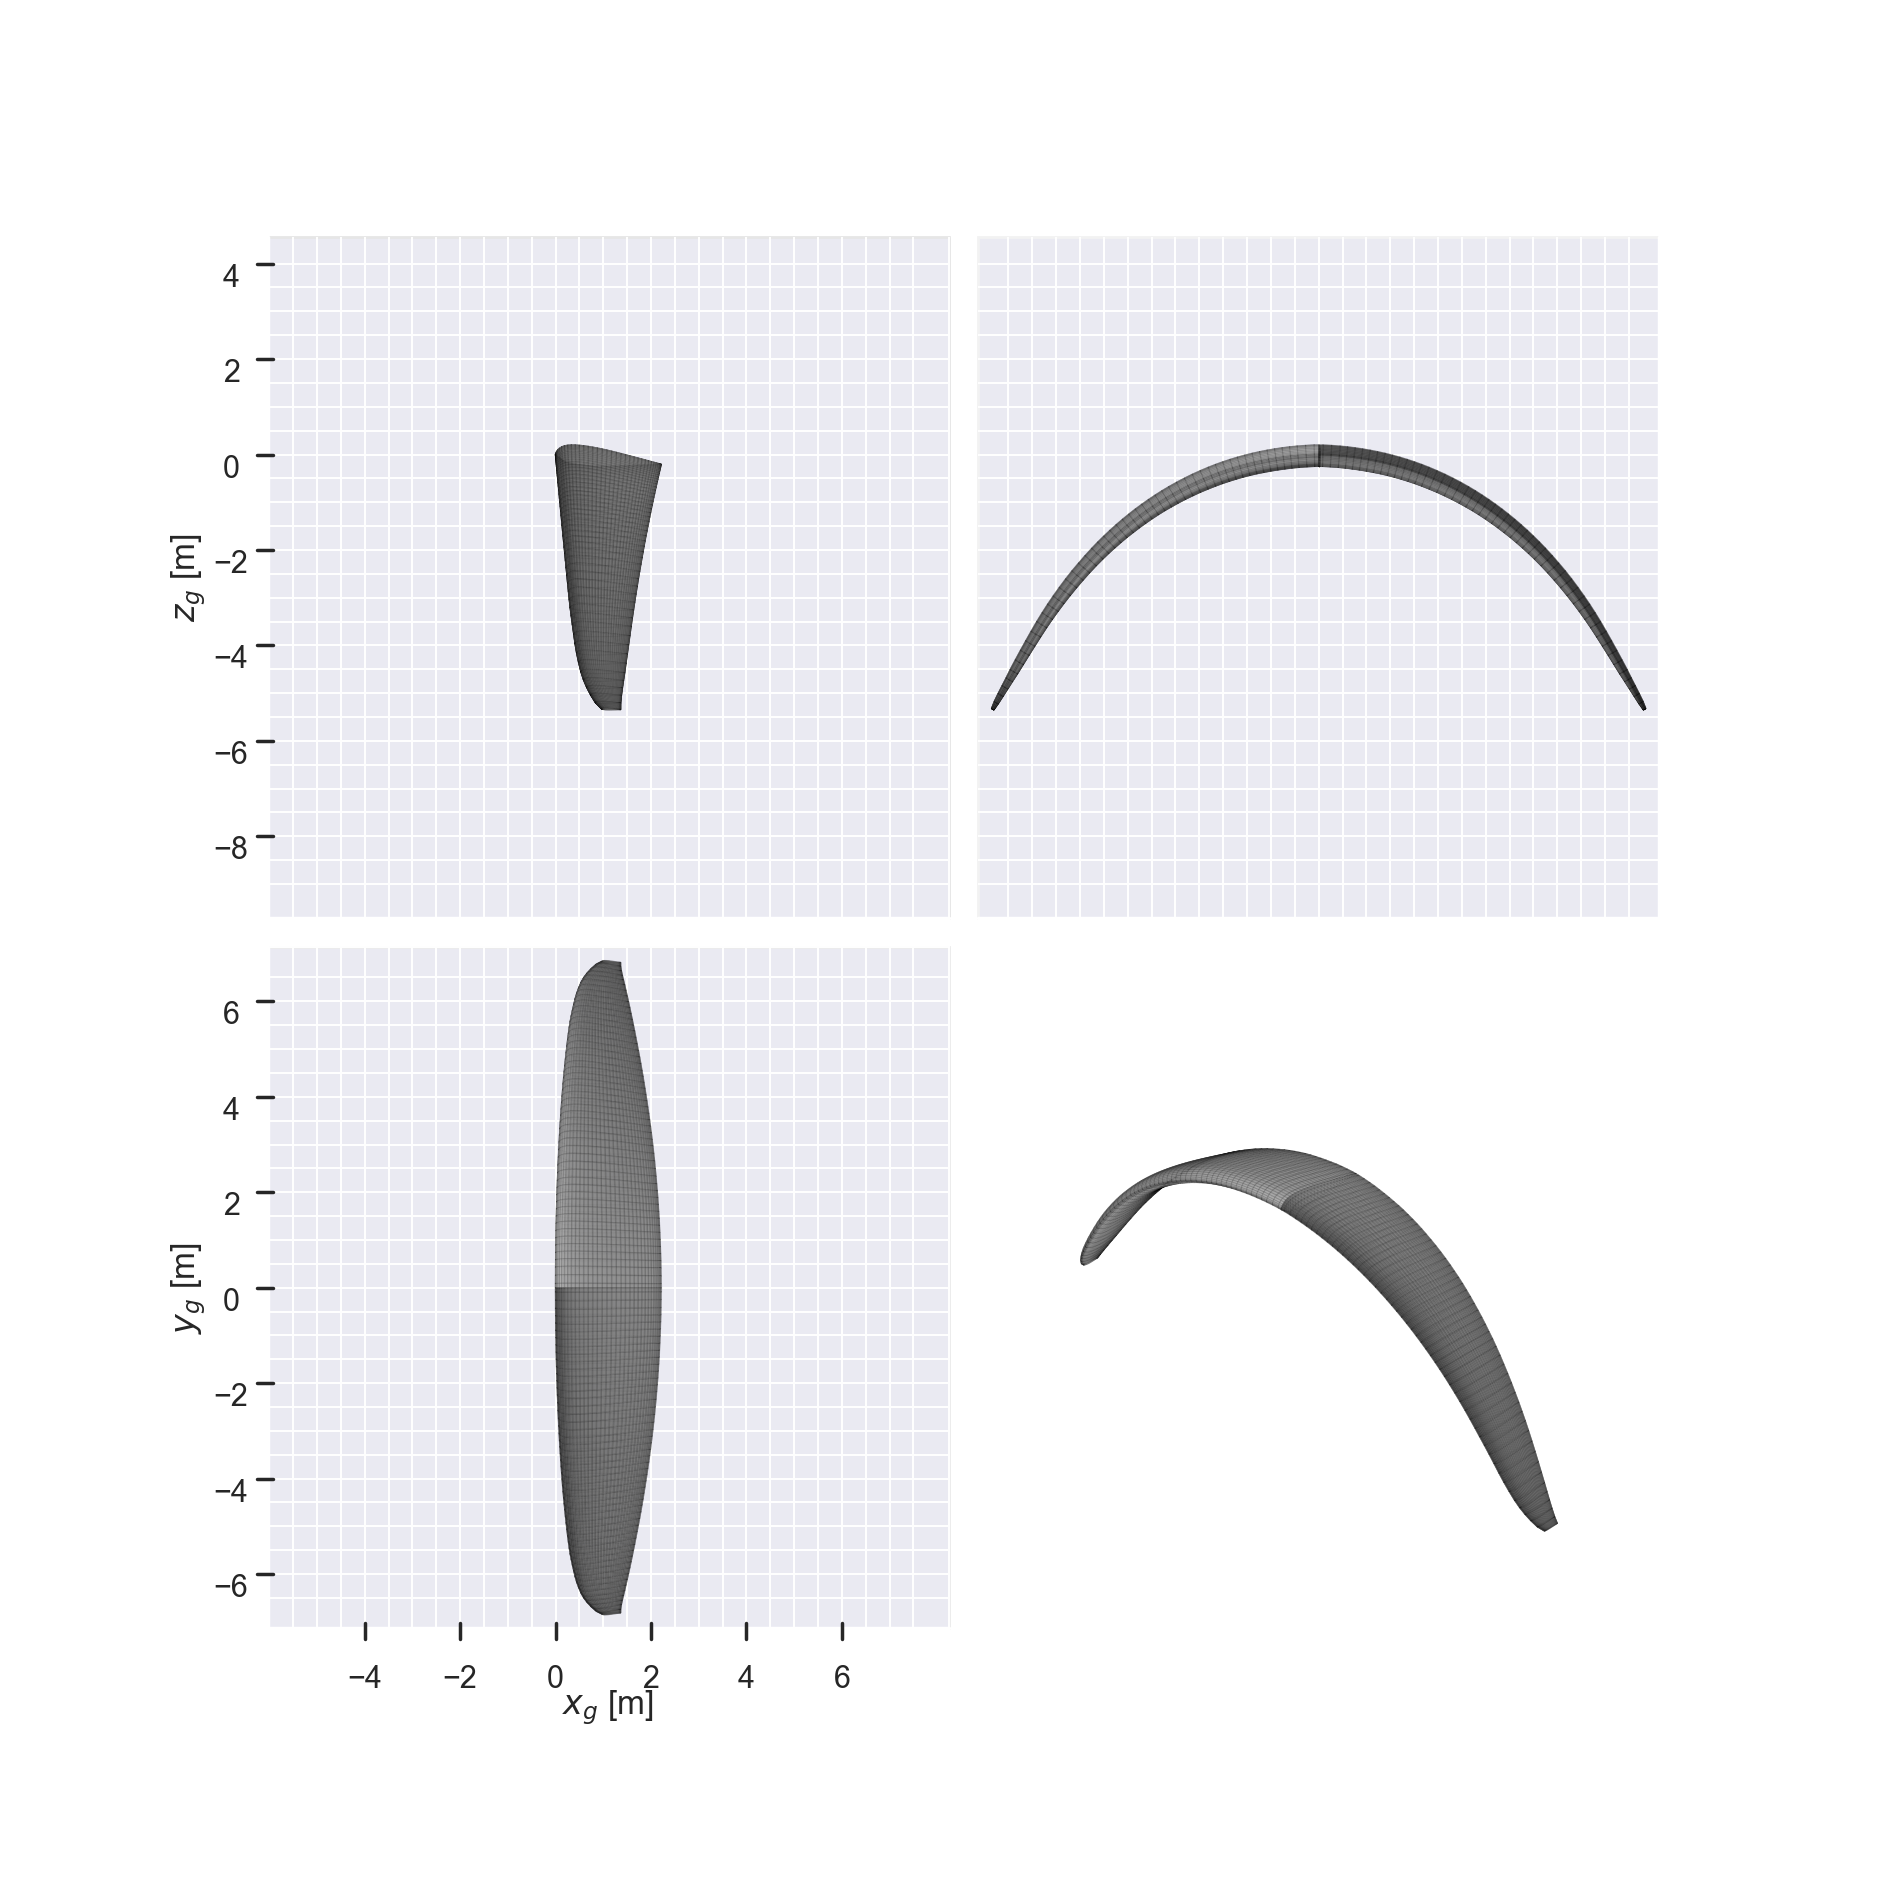

In [23]:
if __name__ == "__main__":
    foldername = "Enzo3"

    folder_to_load = os.path.join(os.getcwd(), "xflr5_file", foldername)
    airplane = import_from_xflr5_with_airfoils(
        folder_to_load, force_midle=True, derotate=False, draw_three_view=True,
    )